In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
df = pd.read_csv('../COVID-19/200423COVID19MEXICO.csv', encoding='latin-1')
toDrop = ['ID_REGISTRO', 'ORIGEN', 'SECTOR', 'MIGRANTE', 'PAIS_ORIGEN']
df.drop(toDrop, axis=1, inplace=True)

In [2]:
dates = ['FECHA_ACTUALIZACION', 'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF']

df[dates] = df[dates].transform(pd.to_datetime, errors='coerce')

df['DIAS_PRE_HOSP'] = (df.FECHA_INGRESO - df.FECHA_SINTOMAS).dt.days
df['DIAS_PRE_DEF'] = (df.FECHA_DEF - df.FECHA_INGRESO).dt.days
df['DIAS_TOT'] = df.DIAS_PRE_HOSP + df.DIAS_PRE_DEF

In [3]:
df['SOBREVIVE'] = df.FECHA_DEF.isnull().astype(int)
df.SEXO = df.SEXO - 1
df.TIPO_PACIENTE = df.TIPO_PACIENTE - 1

prev = ['NEUMONIA', 'DIABETES', 'EPOC',
        'ASMA', 'INMUSUPR', 'HIPERTENSION',
        'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
        'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO',
        'RESULTADO', 'INTUBADO', 'NACIONALIDAD',
        'EMBARAZO', 'HABLA_LENGUA_INDIG', 'UCI']

for p in prev:
    df[p] = [0 if row == 2
               else 1 if row == 1
               else np.nan
               for row in df[p]]

In [4]:
new_cases = df[df.RESULTADO == 1].groupby('FECHA_SINTOMAS').size()
new_deaths = df[df.SOBREVIVE == 0].groupby('FECHA_SINTOMAS').size()
nd_cov = (df[(df.SOBREVIVE == 0) & (df.RESULTADO == 1)]
          .groupby('FECHA_SINTOMAS')
          .size())

cum_cases = new_cases.cumsum()
cum_deaths = new_deaths.cumsum()
cum_nd_cov = nd_cov.cumsum()

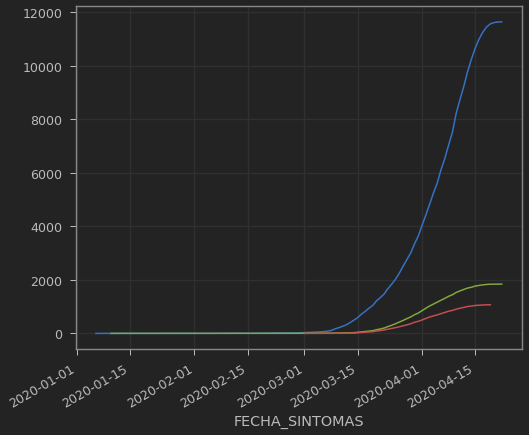

In [5]:
cum_cases.plot()
cum_deaths.plot()
cum_nd_cov.plot()

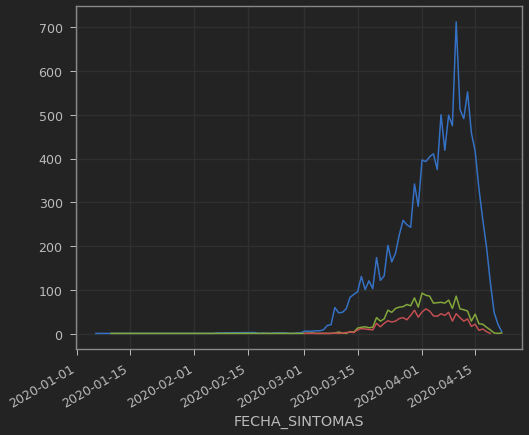

In [6]:
new_cases.plot()
new_deaths.plot()
nd_cov.plot()

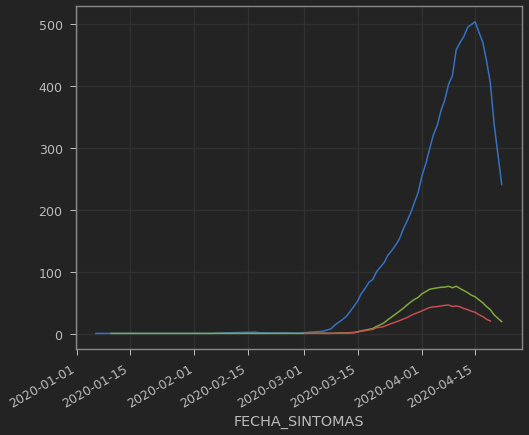

In [7]:
w = '10d'
nc_roll = new_cases.rolling(w)
nd_roll = new_deaths.rolling(w)
ndc_roll = nd_cov.rolling(w)

nc_roll.mean().plot()
nd_roll.mean().plot()
ndc_roll.mean().plot()

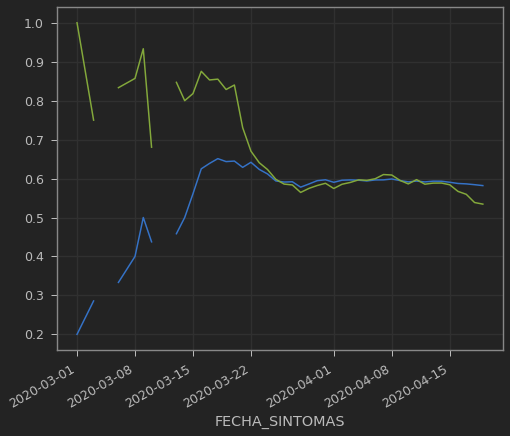

In [8]:
(cum_nd_cov / cum_deaths).plot()
(ndc_roll.mean() / nd_roll.mean()).plot()

In [9]:
df.columns.values

array(['FECHA_ACTUALIZACION', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_NAC',
       'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'FECHA_INGRESO',
       'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA', 'EDAD',
       'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES',
       'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'RESULTADO', 'PAIS_NACIONALIDAD', 'UCI',
       'DIAS_PRE_HOSP', 'DIAS_PRE_DEF', 'DIAS_TOT', 'SOBREVIVE'],
      dtype=object)

In [61]:
to_drop = ['FECHA_ACTUALIZACION', 'FECHA_INGRESO',
           'FECHA_SINTOMAS', 'FECHA_DEF', 'DIAS_PRE_DEF',
           'DIAS_TOT', 'PAIS_NACIONALIDAD', 'MUNICIPIO_RES',
           'TIPO_PACIENTE', 'INTUBADO', 'UCI',
           'RESULTADO', 'NEUMONIA', 'ENTIDAD_UM', 'ENTIDAD_NAC']
dfp = df.drop(to_drop, axis=1)

In [62]:
e_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
         20,21,22,23,24,25,26,27,28,29,30,31,32,36,97,98,99]
e_ab = ['Aguascalientes','Baja California','Baja California Sur','Campeche','Coahuila',
        'Colima','Chiapas','Chihuahua','Ciudad de México','Durango',
        'Guanajuato','Guerrero','Hidalgo','Jalisco','Estado de México',
        'Michoacán','Morelos','Nayarit','Nuevo León','Oaxaca',
        'Puebla','Querétaro','Quintana Roo','San Luis Potosí','Sinaloa',
        'Sonora','Tabasco','Tamaulipas','Tlaxcala','Veracruz',
        'Yucatán','Zacatecas','Estados Unidos Mexicanos','No Aplica','Se Ignora','No Especificado']
mun = {k: v for k, v in zip(e_num, e_ab)}
dfp.rename(columns={
#                     'ENTIDAD_UM': 'Unidad_Medica',
#                     'ENTIDAD_NAC': 'Entidad_Nacimiento',
                    'ENTIDAD_RES': 'Estado',
#                     'RESULTADO': 'Prueba COVID',
#                     'TIPO_PACIENTE': 'Hospitalizado',
                    'DIAS_PRE_HOSP': 'Días Sintomático sin Hospitalizar',
                    'OTRO_CASO': 'Otra Enfermedad Pre-existente',
                    'SEXO': 'Sexo Masculino',
                    'HABLA_LENGUA_INDIG': 'Habla Lengua Indígena'
                   },
           inplace=True)
ents = [
#         'Unidad_Medica',
#         'Entidad_Nacimiento',
        'Estado'
       ]
dfp.replace({e: mun for e in ents}, inplace=True)
dfp.EDAD = pd.cut(dfp.EDAD, 6)

to_onehot = ['EDAD'] + ents
ohs = {toh: pd.get_dummies(dfp[toh]).add_prefix(toh + '_') for toh in to_onehot}
for toh in to_onehot:
    dfp = (dfp.drop(toh, axis=1)
       .join(ohs[toh]))

dfp.fillna(dfp.mode().iloc[0], inplace=True)

### ML Models to Predict Survival

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz

data = dfp.drop('SOBREVIVE', axis=1)
target = dfp.SOBREVIVE

clf = DecisionTreeClassifier(max_depth=6)
cross_val_score(clf, data, target, cv=10)

array([0.96841569, 0.96790627, 0.96773646, 0.96790627, 0.96807607,
       0.96807065, 0.96807065, 0.96807065, 0.96807065, 0.96858016])

In [64]:
clf = clf.fit(data, target)
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=data.columns.values,
                                class_names=['Muere', 'Sobrevive'],
                                filled=True, rounded=True,
                                special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render('../Graphics/covid_dt', view=True)

'../Graphics/covid_dt.pdf'